# WIP

## Table of Contents

### 1. [Introduction](#introduction)
### 2. [Data Handling](#datahandling)
### 3. [Data insight and visualization](#datainsight)

## 1. Introduction <a class="anchor" id="introduction"></a>

The idea of this project is that we want to try and predict the stock price of Telenor ASA. We are going to try to make a model that takes in several variables and uses them to make a prediction as precise as possible. Of the variables we incorporate in our model at the start of this project, we will analyze which of them make the model better and eliminate the rest.
We acknowledge that making precise predictions about Telenor’s stock price is rather far fetched, seeing that if it were this easy people all over the world would do the same, but we want to give VictÅÅÅr a huge challenge. 


## 2. Data Handling <a class="anchor" id="introduction"></a>

### a. Finding appropriate dataset

Our dependent variable must obviously be Telenor ASA's stock prices over a sertian amount of time, seeing that this is what we want to be able to predict. From Yahoo Finance we found Telenor's monthly stock price in Norwegian kroner as of 01.31.2010 too 09.31.2022. In the Dataframe that we make later in this task we have call the Telenor's monthly stockprice series for "TEL". 

To predict the stock price as best as we possibly can, we want to gather data on different variables that we belive will have a significant effect on the stock price. If the variables have a significant effect, they will help us predict the price. We have gathered a variaty of different data/ variables that expand over the sema timespand as our dependent variable "TEL". These independent variables are: 

        1. SP500 (which is a market-capitalization-weighted index of the 500 leading publicly traded companies in the U.S.)
        2. VIX (Is a measure of the market's expectation of volatility)
        3. BRENT_SPOT (Is the monthly pricing of crude oil)
        4. DNB ("Den Norske Bank's" monthly stock price)
        5. FDX (Fedex monthly stock price)
        6. EQNR (Equinor's monthly stock price)
        7. MOWI (Norway's biggest exporter of seafood)
        8. Monthly_KPI (The Norwegian monthly consumer price index)
        9. Policy rate (The Norwegian monthly policy rate)
        10. TEL_PCT_Change (The monthly change in Telenor's stock price, in percent)
        11. TEL_IS_POS (Wether the monthly change in Telenor's stock price is positive or negative)



* Hvorfor har vi valgt den dataen vi har valgt
* Hvor har vi fått dataen vår fra?
* Hva gjør at vi har valgt de forskjellige dataene

### b. Creating our dataset

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
#from keras.models import Sequential
#from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
#import tensorflow as tf
import numpy as np
import pandasdmx as sdmx
from pyjstat import pyjstat
import requests

In [2]:
stocks = ['^GSPC', "^VIX" , 'BZ=F', 'DNB.OL',"FDX", 'TEL.OL', 'EQNR.OL', "MOWI.OL"]
f = web.DataReader(stocks, 'yahoo',start='2010-01-01',end='2022-09-30')
df = f[[("Close", s) for s in stocks]]
df.columns = df.columns.droplevel(level=0)
df.reset_index(inplace=True)

In [3]:
df.tail()

Symbols,Date,^GSPC,^VIX,BZ=F,DNB.OL,FDX,TEL.OL,EQNR.OL,MOWI.OL
3285,2022-09-26,3655.040039,32.259998,84.059998,176.000000,142.899994,103.449997,344.450012,173.449997
3286,2022-09-27,3647.290039,32.599998,86.269997,177.000000,144.949997,106.550003,352.799988,170.050003
3287,2022-09-28,3719.040039,30.180000,89.320000,174.449997,149.990005,104.400002,353.799988,137.899994
3288,2022-09-29,3640.469971,31.840000,88.489998,169.300003,152.309998,101.500000,348.950012,133.550003
3289,2022-09-30,3585.620117,31.620001,87.959999,172.850006,148.470001,99.660004,358.100006,138.500000


In [4]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
stocksmonthly = df.resample('1M').mean()

In [5]:
stocksmonthly.rename(columns={"DNB.OL" : "DNB"}, inplace=True)
stocksmonthly.rename(columns={"MOWI.OL" : "MOWI"}, inplace=True)
stocksmonthly.rename(columns={"TEL.OL" : "TEL"}, inplace=True)
stocksmonthly.rename(columns={"EQNR.OL" : "EQNR"}, inplace=True)
stocksmonthly.rename(columns={"^GSPC" : "SP500"}, inplace=True)
stocksmonthly.rename(columns={"^VIX" : "VIX"}, inplace=True)
stocksmonthly.rename(columns={"BZ=F" : "BRENT_SPOT"}, inplace=True)

In [6]:
stocksmonthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 2010-01-31 to 2022-09-30
Freq: M
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SP500       153 non-null    float64
 1   VIX         153 non-null    float64
 2   BRENT_SPOT  153 non-null    float64
 3   DNB         152 non-null    float64
 4   FDX         153 non-null    float64
 5   TEL         153 non-null    float64
 6   EQNR        153 non-null    float64
 7   MOWI        153 non-null    float64
dtypes: float64(8)
memory usage: 10.8 KB


We notice in the infochart that our DNB variable is incomplete and we will address this by filling it with the mean of the month prior and the month after, ensuring a not to unrealsitic estimate.

In [7]:
stocksmonthly["DNB"] = (stocksmonthly["DNB"].ffill()+stocksmonthly["DNB"].bfill())/2

In [8]:
POST_URL = 'https://data.ssb.no/api/v0/no/table/05327/'

In [9]:
payload = {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "item",
        "values": [
          "JA_TOTAL"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KPIJustIndMnd"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2010M01",
          "2010M02",
          "2010M03",
          "2010M04",
          "2010M05",
          "2010M06",
          "2010M07",
          "2010M08",
          "2010M09",
          "2010M10",
          "2010M11",
          "2010M12",
          "2011M01",
          "2011M02",
          "2011M03",
          "2011M04",
          "2011M05",
          "2011M06",
          "2011M07",
          "2011M08",
          "2011M09",
          "2011M10",
          "2011M11",
          "2011M12",
          "2012M01",
          "2012M02",
          "2012M03",
          "2012M04",
          "2012M05",
          "2012M06",
          "2012M07",
          "2012M08",
          "2012M09",
          "2012M10",
          "2012M11",
          "2012M12",
          "2013M01",
          "2013M02",
          "2013M03",
          "2013M04",
          "2013M05",
          "2013M06",
          "2013M07",
          "2013M08",
          "2013M09",
          "2013M10",
          "2013M11",
          "2013M12",
          "2014M01",
          "2014M02",
          "2014M03",
          "2014M04",
          "2014M05",
          "2014M06",
          "2014M07",
          "2014M08",
          "2014M09",
          "2014M10",
          "2014M11",
          "2014M12",
          "2015M01",
          "2015M02",
          "2015M03",
          "2015M04",
          "2015M05",
          "2015M06",
          "2015M07",
          "2015M08",
          "2015M09",
          "2015M10",
          "2015M11",
          "2015M12",
          "2016M01",
          "2016M02",
          "2016M03",
          "2016M04",
          "2016M05",
          "2016M06",
          "2016M07",
          "2016M08",
          "2016M09",
          "2016M10",
          "2016M11",
          "2016M12",
          "2017M01",
          "2017M02",
          "2017M03",
          "2017M04",
          "2017M05",
          "2017M06",
          "2017M07",
          "2017M08",
          "2017M09",
          "2017M10",
          "2017M11",
          "2017M12",
          "2018M01",
          "2018M02",
          "2018M03",
          "2018M04",
          "2018M05",
          "2018M06",
          "2018M07",
          "2018M08",
          "2018M09",
          "2018M10",
          "2018M11",
          "2018M12",
          "2019M01",
          "2019M02",
          "2019M03",
          "2019M04",
          "2019M05",
          "2019M06",
          "2019M07",
          "2019M08",
          "2019M09",
          "2019M10",
          "2019M11",
          "2019M12",
          "2020M01",
          "2020M02",
          "2020M03",
          "2020M04",
          "2020M05",
          "2020M06",
          "2020M07",
          "2020M08",
          "2020M09",
          "2020M10",
          "2020M11",
          "2020M12",
          "2021M01",
          "2021M02",
          "2021M03",
          "2021M04",
          "2021M05",
          "2021M06",
          "2021M07",
          "2021M08",
          "2021M09",
          "2021M10",
          "2021M11",
          "2021M12",
          "2022M01",
          "2022M02",
          "2022M03",
          "2022M04",
          "2022M05",
          "2022M06",
          "2022M07",
          "2022M08",
          "2022M09"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

In [10]:
result = requests.post(POST_URL, json = payload)

In [11]:
dataset = pyjstat.Dataset.read(result.text)
KPI_JA = dataset.write('dataframe')

In [12]:
stocksmonthly["Monthly_KPI"] = KPI_JA["value"].values

In [13]:
rate = pd.read_csv("https://data.norges-bank.no/api/data/IR/M.KPRA.SD.R?apisrc=qb&format=csv&startPeriod=2010-01-01&endPeriod=2022-09-01&locale=no&bom=include", sep=";", decimal=",")

In [14]:
rate.head()

,FREQ,Frekvens,INSTRUMENT_TYPE,Instrumenttype,TENOR,Løpetid,UNIT_MEASURE,Måleenhet,DECIMALS,COLLECTION,Innsamlingstidspunkt,TIME_PERIOD,OBS_VALUE,CALC_METHOD,Calculation Method
0,M,Månedlig,KPRA,Styringsrenten,SD,Foliorenten,R,Rente,2,A,Gjennomsnitt av observasjoner gjennom perioden,2010-01,1.75,NaN,NaN
1,M,Månedlig,KPRA,Styringsrenten,SD,Foliorenten,R,Rente,2,A,Gjennomsnitt av observasjoner gjennom perioden,2010-02,1.75,NaN,NaN
2,M,Månedlig,KPRA,Styringsrenten,SD,Foliorenten,R,Rente,2,A,Gjennomsnitt av observasjoner gjennom perioden,2010-03,1.75,NaN,NaN
3,M,Månedlig,KPRA,Styringsrenten,SD,Foliorenten,R,Rente,2,A,Gjennomsnitt av observasjoner gjennom perioden,2010-04,1.75,NaN,NaN
4,M,Månedlig,KPRA,Styringsrenten,SD,Foliorenten,R,Rente,2,A,Gjennomsnitt av observasjoner gjennom perioden,2010-05,1.96,NaN,NaN


In [15]:
stocksmonthly["Policy_Rate"] = rate["OBS_VALUE"].values

In [21]:
#stocksmonthly["Monthly_KPI_Change_PCT"] = stocksmonthly.Monthly_KPI.pct_change()*100

In [16]:
stocksmonthly["TEL_PCT_Change"] = stocksmonthly["TEL"].pct_change()*100

In [17]:
stocksmonthly["TEL_IS_POS"] = np.where(stocksmonthly.TEL_PCT_Change>0, 1, 0)

In [18]:
stocksmonthly.head()

Symbols,SP500,VIX,BRENT_SPOT,DNB,FDX,TEL,EQNR,MOWI,Monthly_KPI,Policy_Rate,TEL_PCT_Change,TEL_IS_POS
Date,,,,,,,,,,,,
2010-01-31,1123.581582,20.643158,77.008421,66.472499,83.260000,79.355000,142.719999,46.971000,91.1,1.75,NaN,0
2010-02-28,1089.159989,22.540000,74.909999,64.467500,80.504211,75.627500,132.040000,52.585000,92.4,1.75,-4.697247,0
2010-03-31,1152.048690,17.767391,79.931304,67.847826,88.973478,79.454348,136.443479,51.529565,92.8,1.75,5.060128,1
2010-04-30,1197.316185,17.424286,85.753810,68.315789,91.950001,84.192105,144.047369,54.081579,93.0,1.75,5.962867,1
2010-05-31,1125.062006,31.929500,76.664737,65.055555,85.434000,80.877778,134.416667,54.419445,92.5,1.96,-3.936624,0


In [ ]:
stocksmonthly.to_csv("stocksmonthly_csv.csv")

## 3. Data insight and visualization <a class="anchor" id="datainsight"></a>

### Graph

### Scatterplot

### Histogram

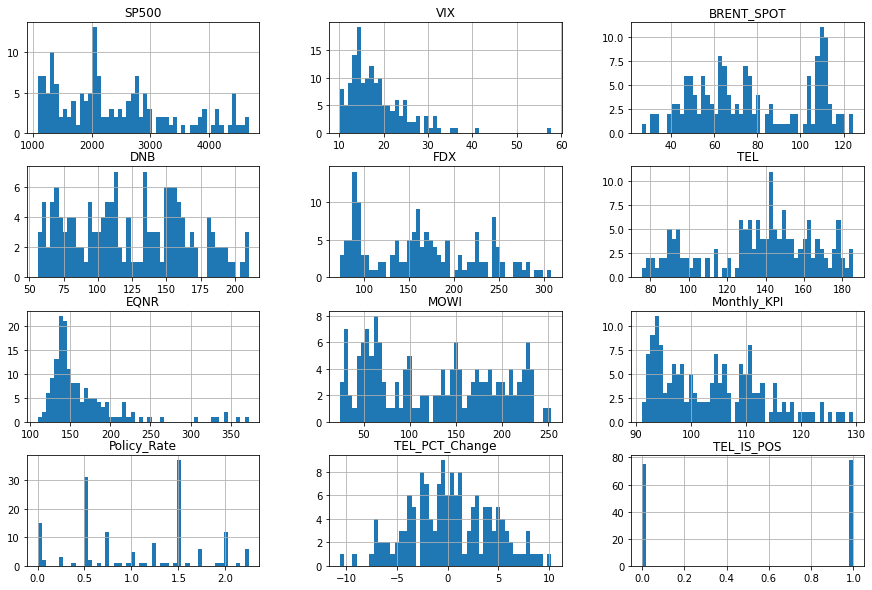

In [25]:
stocksmonthly.hist(bins=50, figsize=(15,10))
plt.show()

### Joint distribution

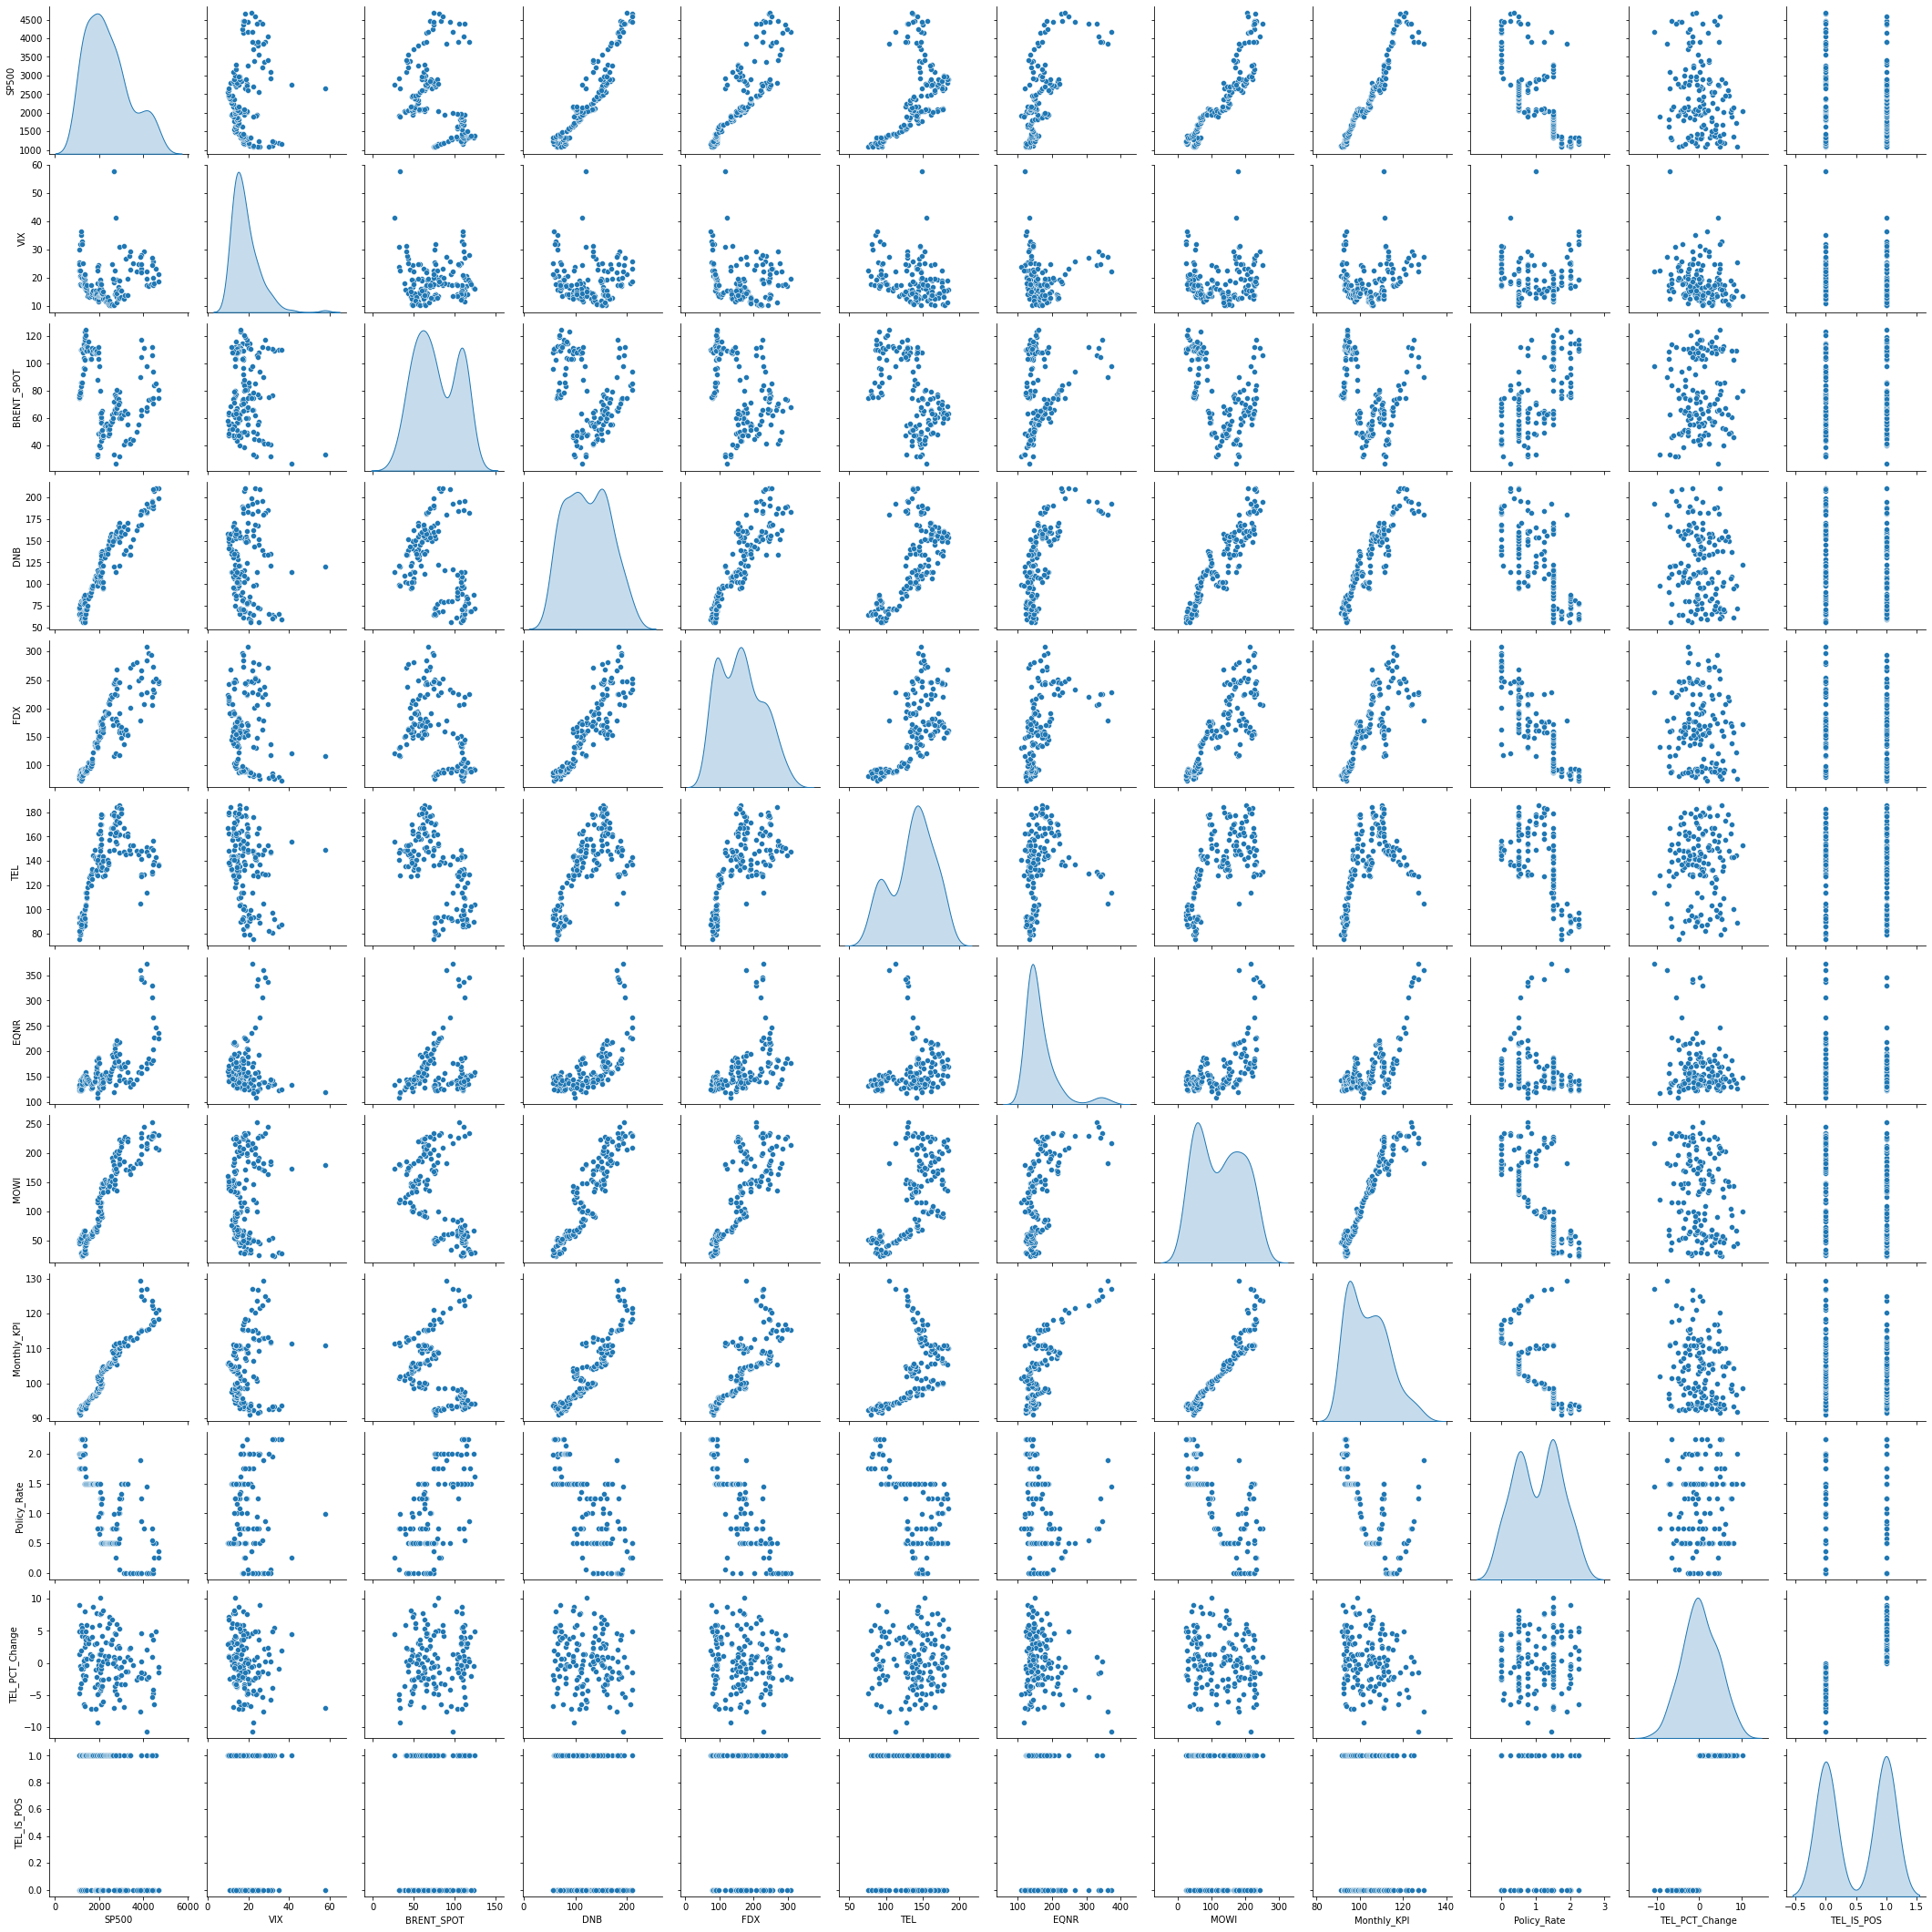

In [26]:
sns.pairplot(stocksmonthly, diag_kind='kde')
plt.show()

### Boxplots

<AxesSubplot:>

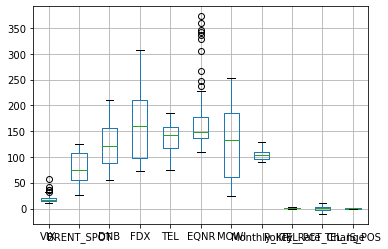

In [27]:
stocksmonthly.drop(["SP500"], axis=1).boxplot()

## 4. Basic statistics

### Mean and median

### Minimum and maximum values

### Standard deviation and average deviation

### Quantiles and percentiles

### Correlation

## 5. Data preparation for machine learning

## 6. Model training and analysis

## 7. Discussion and implementation

## 8. Conclusion

## 9. References

SSB \
Norges Bank \
Yahoo

## 10. Word Count

In [3]:
import json

with open('Arbeidskrav.ipynb') as json_file:
    data = json.load(json_file)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] 
            wordCount = wordCount + len(temp)
            
print("We have", wordCount, "words excluding coding blocks.")

We have 411 words excluding coding blocks.
